<a href="https://colab.research.google.com/github/Calcifer777/learn-nlp/blob/main/fine-tuning/layoutxlm_ft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q transformers datasets seqeval peft

In [ ]:
# !pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
!git clone https://github.com/facebookresearch/detectron2
%cd /content/detectron2
!pip install -r requirements.txt
!python setup.py install
# !pip install git+https://github.com/facebookresearch/fvcore.git

In [1]:
from transformers import (
    LayoutXLMProcessor,
    LayoutLMv2ForTokenClassification,
)
from datasets import load_dataset, load_metric
from transformers import AdamW
from PIL import Image
from functools import partial
from torch.utils.data import DataLoader, RandomSampler
from torch.optim import NAdam, AdamW
from torch.optim.lr_scheduler import (
    CosineAnnealingLR,
    LambdaLR,
    SequentialLR,
)
import torch
from tqdm import tqdm
from pprint import pprint
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot as plt
import logging

In [2]:
%load_ext tensorboard

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [4]:
BATCH_SIZE = 4

WARMUP_STEPS = 10
EPOCHS = 5
LR = 5e-4

In [5]:
model_id = "microsoft/layoutxlm-base"

preprocessor = LayoutXLMProcessor.from_pretrained(model_id, apply_ocr=False)

/usr/local/lib/python3.9/dist-packages/transformers/models/layoutlmv2/feature_extraction_layoutlmv2.py:30: FutureWarning: The class LayoutLMv2FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv2ImageProcessor instead.
  warnings.warn(


In [6]:
ds = load_dataset("nielsr/funsd")

  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
labels = ds['train'].features['ner_tags'].feature.names
id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}
labels

['O',
 'B-HEADER',
 'I-HEADER',
 'B-QUESTION',
 'I-QUESTION',
 'B-ANSWER',
 'I-ANSWER']

In [8]:
ds["train"][0].keys()

dict_keys(['id', 'words', 'bboxes', 'ner_tags', 'image_path'])

In [9]:
def collate_fn(batch, model) -> dict:
  images, text, boxes, word_labels = [], [], [], []
  for record in batch:
    boxes.append(record["bboxes"])
    images.append(Image.open(record["image_path"]).convert("RGB"))
    text.append(record["words"])
    word_labels.append(record["ner_tags"])
  return model(
    images=images,
    text=text,
    boxes=boxes,
    word_labels=word_labels,
    truncation=True,
    padding=True,
    return_tensors="pt",
    max_length=512,
  )

In [11]:
fn = partial(collate_fn, model=preprocessor)

# train_sampler = RandomSampler(ds["train"], replacement=True, num_samples=STEPS*BATCH_SIZE)

dl_train = DataLoader(ds["train"], batch_size=BATCH_SIZE, collate_fn=fn) # , sampler=train_sampler)
dl_test = DataLoader(ds["test"], batch_size=BATCH_SIZE, collate_fn=fn)

In [12]:
batch = next(iter(dl_train))
print(f"{batch.keys()=}")
print(f"{batch['bbox'].shape=}")

batch.keys()=dict_keys(['input_ids', 'attention_mask', 'bbox', 'labels', 'image'])
batch['bbox'].shape=torch.Size([4, 512, 4])


In [13]:
model = (
    LayoutLMv2ForTokenClassification
    .from_pretrained(model_id, num_labels=len(labels))
    .to(device)
)

Some weights of the model checkpoint at microsoft/layoutxlm-base were not used when initializing LayoutLMv2ForTokenClassification: ['layoutlmv2.visual.backbone.bottom_up.res2.2.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.10.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.7.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res3.2.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.stem.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.10.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res5.2.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res3.3.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.18.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.0.shortcut.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res5.1.conv3.norm.num_batches_tracked', 'layou

In [14]:
# outputs = model(
#     input_ids=batch["input_ids"].to(device),
#     bbox=batch["bbox"].to(device),
#     image=batch["image"].to(device),
# )
# print(f"{outputs.loss=}")
# print(f"{outputs.logits.shape=}")

In [15]:
def validate_batch(batch, model, metric, device):
  with torch.inference_mode():
    labels = batch['labels'].to(device)
    outputs = model(
      input_ids=batch['input_ids'].to(device), 
      bbox=batch['bbox'].to(device), 
      image=batch['image'].to(device),
      labels=labels,
    )
    predictions = outputs.logits.argmax(dim=-1)
    loss = outputs.loss.item()
    y_true, y_pred = list(), list()
    for vec_pred, vec_label in zip(predictions, labels):
      acc_y_true, acc_y_pred = list(), list()
      for tkn_pred, tkn_label in zip(vec_pred, vec_label):
        if tkn_label != -100:
          acc_y_pred.append(id2label[tkn_pred.item()])
          acc_y_true.append(id2label[tkn_label.item()])
      y_true.append(acc_y_true)
      y_pred.append(acc_y_pred)

    metric.add_batch(predictions=y_pred, references=y_true)
  return loss

In [16]:
def validate(data_loader, model, device):
  metric = load_metric("seqeval")
  losses = []
  for batch in data_loader: 
    loss = validate_batch(batch, model, metric, device)
    losses.append(loss)
  metrics = metric.compute()
  logging.warning(
    f"Loss: {metrics['overall_f1']:.3f} - "
    f"Acc: {metrics['overall_accuracy']:.3%} - "
    f"Recall {metrics['overall_recall']:.3%} - "
    f"F1: {metrics['overall_f1']:.3%}"
  )
  return np.mean(losses), metrics

In [17]:
_ = validate(dl_test, model, device)

<ipython-input-16-a7a728e91053>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


In [18]:
def train_step(batch, model, optimizer, device):
  model.train()
  optimizer.zero_grad()
  outputs = model(
      input_ids=batch["input_ids"].to(device),
      bbox=batch["bbox"].to(device),
      image=batch["image"].to(device),
      labels=batch["labels"].to(device),
  )
  loss, logits = outputs.loss, outputs.logits
  loss.backward()
  optimizer.step()
  return loss, logits

In [19]:
from datetime import datetime

writer = SummaryWriter(log_dir=f"logs/{datetime.now().isoformat()}")
tb_keys = ['overall_precision', 'overall_recall', 'overall_f1', 'overall_accuracy']

In [20]:
def create_scheduler(optimizer, warmup_steps, total_steps):
  warmup_scheduler = LambdaLR(optimizer, lr_lambda=lambda step: float(step / warmup_steps))
  train_scheduler = CosineAnnealingLR(optimizer, T_max=total_steps-warmup_steps, eta_min=1e-5) 
  seq = SequentialLR(optimizer, [warmup_scheduler, train_scheduler], milestones=[warmup_steps])
  return seq

In [21]:
def plot_lr_schedule(scheduler_fn, optimizer_fn, num_steps):
  lrs = []
  optimizer = optimizer_fn([torch.Tensor(1)])
  scheduler = scheduler_fn(optimizer)
  for _ in tqdm(range(num_steps)):
    optimizer.step()
    try:
      lrs.append(scheduler.get_lr())
    except NotImplementedError:
      lrs.append(scheduler.get_last_lr())
    scheduler.step()

  plt.plot(lrs)
  plt.show()

100%|██████████| 500/500 [00:00<00:00, 23647.20it/s]


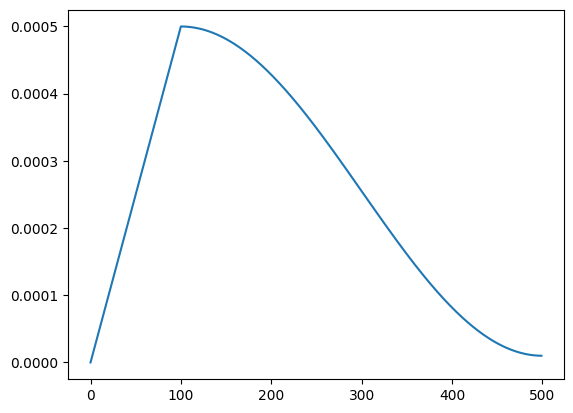

In [22]:
plot_lr_schedule(
  scheduler_fn=partial(create_scheduler, warmup_steps=100, total_steps=500), 
  optimizer_fn=partial(AdamW, lr=LR), 
  num_steps=500,
)

In [23]:
# scheduler = create_scheduler(optimizer, warmup_steps=WARMUP_STEPS, total_steps=STEPS)

In [24]:
LEN_DL = len(dl_train)
STEPS = LEN_DL * EPOCHS
NUM_VALIDATIONS = 10
VAL_STEPS = STEPS // NUM_VALIDATIONS
print(f"{STEPS}")
print(f"{VAL_STEPS}")

190
19


In [25]:
optimizer = AdamW(model.parameters(), lr=5e-5)

In [ ]:
history = {
    "train": { "loss": []},
    "test": { "loss": [], "metrics": []},
}


step_idx = 0
for epoch_idx in range(EPOCHS):
  pbar = tqdm(enumerate(dl_train))
  epoch_losses = []
  for batch_idx, batch in pbar:
    loss, logits = train_step(batch, model, optimizer, device)
    epoch_losses.append(loss.item())
    pbar.set_description(
      " - ".join([
        f"Epoch {epoch_idx}/{EPOCHS}",
        f"Step {batch_idx}/{LEN_DL}",
        f"Loss: {np.mean(epoch_losses):.3f}",
      ])
    )
    # scheduler.step()
  history['train']['loss'].append(np.mean(epoch_losses))
  epoch_test_loss, epoch_metrics = validate(dl_test, model, device)
  history["test"]["loss"].append(epoch_test_loss)
  history["test"]["metrics"].append(epoch_metrics)
  writer.add_scalars("eval", {k: epoch_metrics[k] for k in tb_keys}, step_idx)
  torch.cuda.empty_cache()
  step_idx += 1

Epoch 0/5Step 37/38 - Loss: 1.243: : 38it [00:29,  1.28it/s]
Epoch 1/5Step 37/38 - Loss: 0.729: : 38it [00:28,  1.33it/s]
Epoch 2/5Step 28/38 - Loss: 0.554: : 28it [00:22,  1.25it/s]

In [ ]:
%tensorboard --logdir logs/